<a href="https://colab.research.google.com/github/wereign/aera-vera-keras-nathu-geras/blob/main/Time_Series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [3]:
#Start by connecting gdrive into the google colab

from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_PATH = "/content/gdrive/MyDrive/Colab Notebooks/TF_2_Notebooks_and_Data/"

Mounted at /content/gdrive


In [4]:
csv_path = f"{DRIVE_PATH}/DATA/RSCCASN.csv"

In [9]:
df = pd.read_csv(csv_path,parse_dates=True,index_col="DATE")

In [10]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [12]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

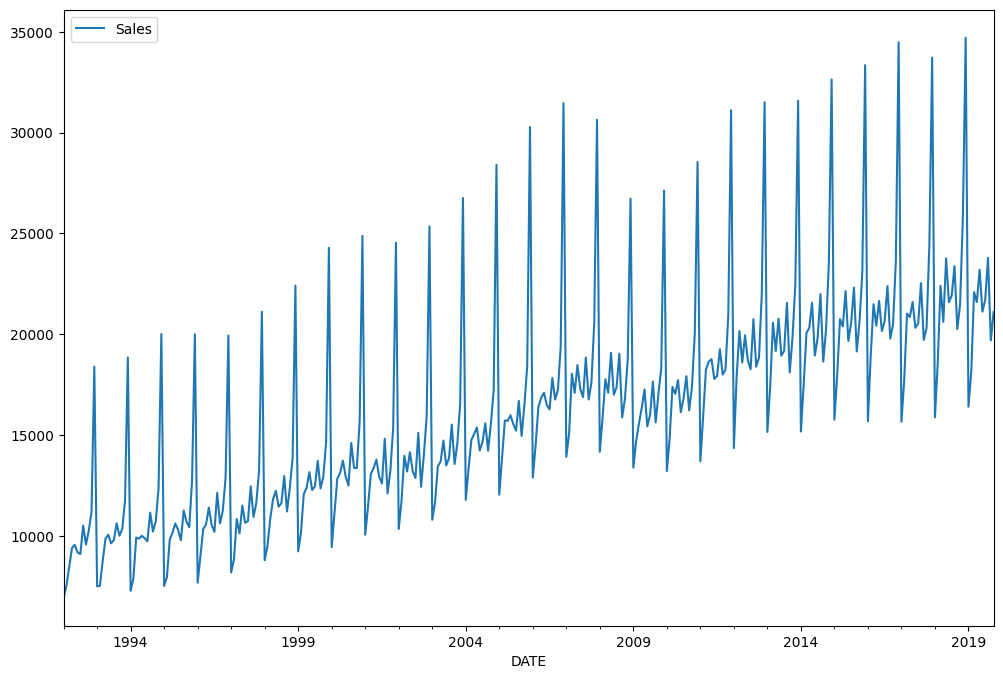

In [13]:
df.plot(figsize=(12,8))

In [14]:
len(df)

334

In [15]:
len(df) - 18

316

In [17]:
test_size = 18
test_ind = len(df) - test_size

In [58]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [59]:
print(test)

            Sales
DATE             
2018-05-01  23764
2018-06-01  21589
2018-07-01  21919
2018-08-01  23381
2018-09-01  20260
2018-10-01  21473
2018-11-01  25831
2018-12-01  34706
2019-01-01  16410
2019-02-01  18134
2019-03-01  22093
2019-04-01  21597
2019-05-01  23200
2019-06-01  21123
2019-07-01  21714
2019-08-01  23791
2019-09-01  19695
2019-10-01  21113


In [60]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [61]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
scaler = MinMaxScaler()

In [63]:
scaler.fit(train)

MinMaxScaler()

In [64]:
scaled_train = scaler.transform(train)

In [65]:
scaled_test = scaler.transform(test)

In [66]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [67]:
# batches need to be smaller than test size

length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [68]:
X,y = generator[0]

In [69]:
# Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [70]:
n_features = 1

In [111]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [112]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [113]:
# early stopping mechanism
from tensorflow.keras.callbacks import EarlyStopping

In [114]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [115]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [116]:
model.fit(generator,epochs=20,validation_data=validation_generator, 
          callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 5s 8ms/step - loss: 0.0278 - val_loss: 0.0103
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0170 - val_loss: 0.0027
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0099 - val_loss: 0.0047
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0040 - val_loss: 0.0038


In [117]:
loss = pd.DataFrame(model.history.history)

<Axes: >

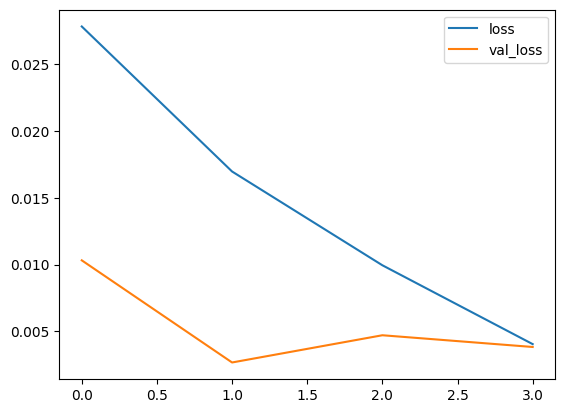

In [118]:
loss.plot()

In [119]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)
  
  # updating the current prediction by adding the prediction to the end
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 31ms/step


In [120]:
true_predictions = scaler.inverse_transform(test_predictions)

In [121]:
test['Predictions'] = true_predictions

<ipython-input-121-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [122]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22402.642954
2018-06-01,21589,21342.096864
2018-07-01,21919,21647.684062
2018-08-01,23381,23574.427481
2018-09-01,20260,21287.791046
2018-10-01,21473,22090.685764
2018-11-01,25831,26684.795729
2018-12-01,34706,39235.152886
2019-01-01,16410,17932.533572


<Axes: xlabel='DATE'>

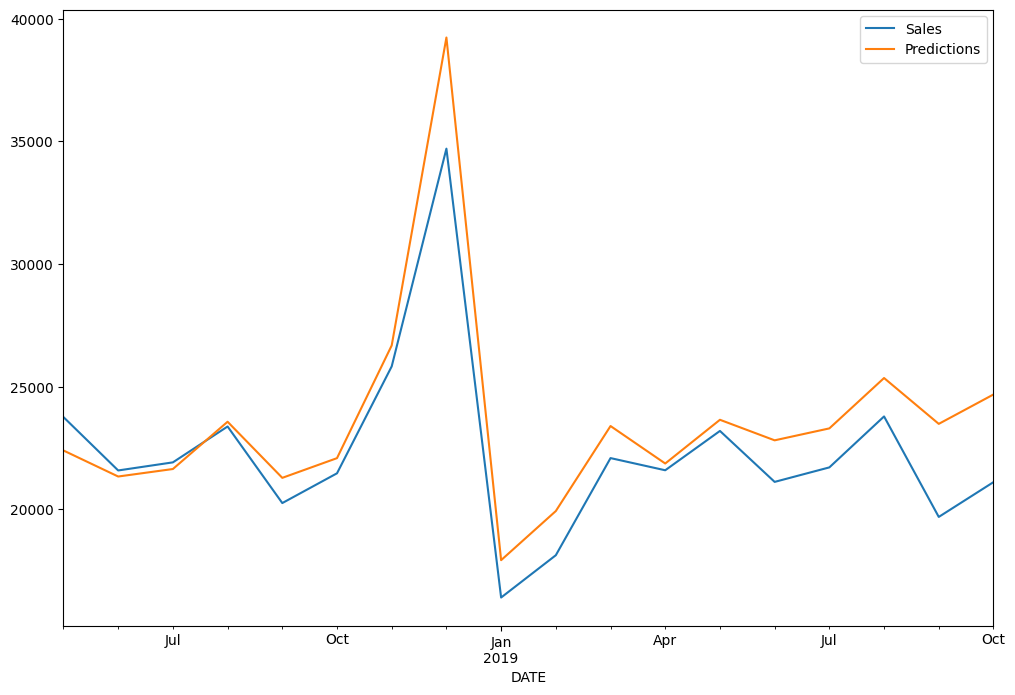

In [123]:
test.plot(figsize=(12,8))

In [125]:
# retraining on all the data for forecasting
full_scaler = MinMaxScaler()
full_scaled = full_scaler.fit_transform(df)

In [126]:
length = 12
generator = TimeseriesGenerator(full_scaled,full_scaled,
                                length=length,batch_size=1)


In [127]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 3s 6ms/step - loss: 0.0244
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0153
Epoch 3/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0060
Epoch 4/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0037
Epoch 5/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 7/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 8/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0016


In [130]:
forecast = []
periods = 12


for i in range(periods):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)
  
  # updating the current prediction by adding the prediction to the end
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 20ms/step


In [131]:
forecast = scaler.inverse_transform(forecast)
print(forecast)

[[24703.08158398]
 [38535.8197794 ]
 [16044.05935407]
 [18038.32221746]
 [20937.03929567]
 [19936.72984576]
 [21378.06925535]
 [20756.34825373]
 [21122.49305534]
 [22691.30863237]
 [21282.4340148 ]
 [22310.09420443]]


In [132]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [133]:
forecast

array([[24703.08158398],
       [38535.8197794 ],
       [16044.05935407],
       [18038.32221746],
       [20937.03929567],
       [19936.72984576],
       [21378.06925535],
       [20756.34825373],
       [21122.49305534],
       [22691.30863237],
       [21282.4340148 ],
       [22310.09420443]])

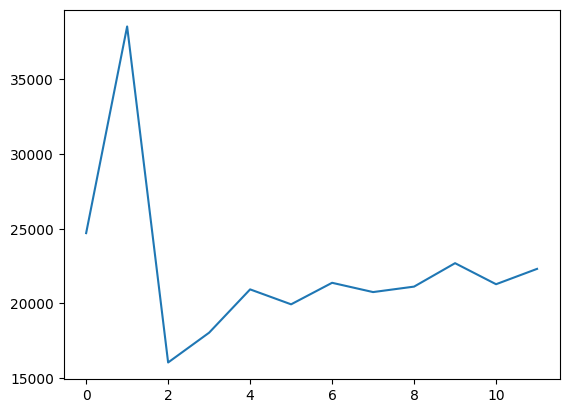

In [135]:
plt.plot(forecast)

In [136]:
# including the predictions with a timestamp

In [139]:
forecast_index = pd.date_range('2019-11-01',periods=periods,freq='MS')

In [140]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [141]:
forecast_df

,Forecast
2019-11-01,24703.081584
2019-12-01,38535.819779
2020-01-01,16044.059354
2020-02-01,18038.322217
2020-03-01,20937.039296
2020-04-01,19936.729846
2020-05-01,21378.069255
2020-06-01,20756.348254
2020-07-01,21122.493055
2020-08-01,22691.308632


<Axes: >

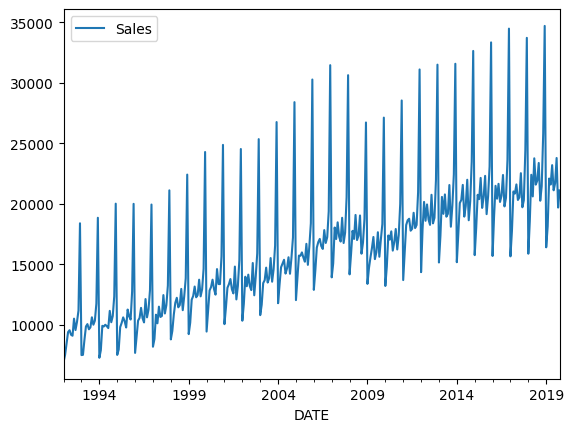

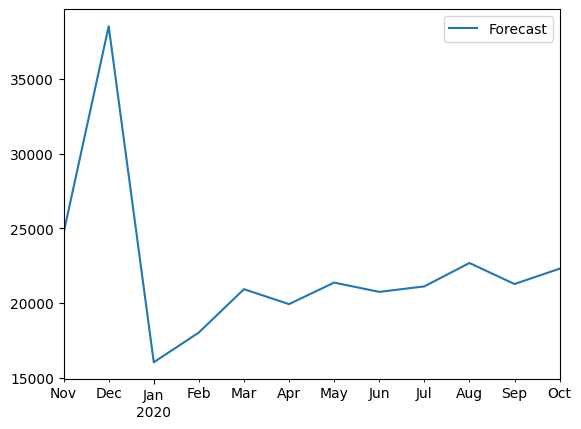

In [142]:
df.plot()
forecast_df.plot()

<Axes: xlabel='DATE'>

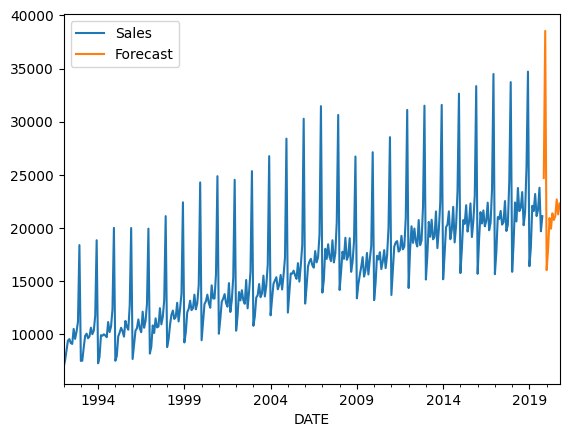

In [143]:
axes = df.plot()
forecast_df.plot(ax=axes)